# FinAI Summit 2025 - Creating and accelerating ML Solutions with Mercury

[Mercury](https://www.bbvaaifactory.com/mercury/) is a modular Python library for Machine Learning and Data Science, developed at **BBVA**. It provides a comprehensive suite of tools designed to streamline and accelerate the creation of ML models, saving valuable development time while offering advanced Data Science functionality. Initially developed as [Inner Source](https://www.bbvaaifactory.com/mercury-acelerando-la-reutilizacion-en-ciencia-de-datos-dentro-de-bbva/), several modules of Mercury have been released as open source.

This notebook demonstrates how easily you can use Mercury to enhance your ML workflows. Whether you're validating datasets, running robust tests, explaining models, or monitoring data drift, Mercury provides an effective solution for each task. In this notebook, we will explore the following modules:

- **mercury-dataschema**: Ensures consistency by validating whether different datasets conform to the same schema.
- **mercury-robust**: Provides robust testing for ML models and datasets, ensuring reliability.
- **mercury-explainability**: Offers tools to interpret ML models, helping you understand model decisions.
- **mercury-monitoring**: Monitors models and data in production environments, detecting issues such as data drift.

## Why Use Mercury?

By leveraging Mercury, you'll experience:

- **Ease of use**: Its intuitive modular design allow seamless integration into your projects.
- **Faster development**: Pre-built components let you focus on building models rather than on redundant tasks.
- **Advanced functionality**: Gain access to tools for [schema validation](https://bbva.github.io/mercury-dataschema/), [model explainability](https://bbva.github.io/mercury-explainability/), [event sequence analysis](https://bbva.github.io/mercury-reels/), [subset querying](https://bbva.github.io/mercury-settrie/), [monitoring](https://bbva.github.io/mercury-monitoring/) of models and data, and [robust testing](https://bbva.github.io/mercury-robust/).

## Try it Yourself!

Explore the code below and modify it to fit your specific use cases. Whether you're validating data or explaining models, you'll find how Mercury simplifies your workflow.

Let’s dive in!

## Install Mercury and Setup

The next cell install the Mercury libraries that we will use. Additionally, we install alibi which is used in mercury-explainability

You may need to restart the kernel after the installation

In [ ]:
# Suppressing error messages as they are related to dependency warnings of packages preinstalled by Kaggle in the environment and not used in the notebook
!pip install -U mercury-dataschema mercury-robust mercury-monitoring mercury-explainability alibi 2>/dev/null
#!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 383.8 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is com

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


random_state= 232
n_sample = 100000

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

## Load Data

In [ ]:
df_url = "https://raw.githubusercontent.com/BBVA/mercury/refs/heads/master/src/data/finai_summit_2025/dataset.csv"
df = pd.read_csv(df_url)

## Preprocessing

Now, we apply some basic preprocessing

In [ ]:
def apply_preprocessing(df):
    # Clean features with high number of nulls
    threshold_nulls = 0.25

    for f in df.columns:
        percent_nulls_f = df[f].isnull().sum() / len(df)
        if percent_nulls_f > threshold_nulls:
            df = df.drop(f, axis=1)


    return df

df = apply_preprocessing(df)

# Drop no feature columns
df = df.drop(['id', 'time'], axis=1)

label_col = "target"
feature_cols = [c for c in df.columns if c!=label_col]

### Train / Test Split

We split the dataset in train and test datasets

In [ ]:
df = df.sample(n=n_sample, random_state=random_state)

df_train, df_test = train_test_split(df, test_size=0.25, random_state=random_state)

## Mercury-Dataschema

[Mercury-dataschema](https://bbva.github.io/mercury-dataschema/) is a utility tool that can auto-infer feature types and calculate different statistics. It is also used in the mercury-robust submodule. In this case, we will create a dataschema to use it later when creating the robust tests with mercury-robust.

Because we had the description of the features, we will manually specify the feature types instead of using the auto-inference.


In [ ]:
from mercury.dataschema.schemagen import DataSchema

categorical_feats = ['type_1']
discrete_feats = ['num_past_requests_1', 'num_past_requests_2', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'num_1', 'num_2', 'num_3', 'num_4']
binary_feats = ['type_2']
continuos_feats = ['payment_1', 'payment_2', 'quantity_1', 'pendent_quantity_1', 'pendent_quanitty_2', 'quantity_2', 'rate_1', 'rate_2', 'quantity_3', 'quantity_4', 'quantity_5', 'amount_1']

schema = DataSchema().generate_manual(
    df_train,
    categ_columns=categorical_feats,
    discrete_columns=discrete_feats,
    binary_columns=binary_feats
)

## Further preprocessing

The next cell transform the categorical features. We will just use an `OrdinalEncoder` for simplicity, but other approaches might be more appropriate in this case.

In [ ]:
encoders = {}
for c in df_train[categorical_feats + binary_feats]:
    encoders[c] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan).fit(df_train[c].values.reshape(-1, 1))
    df_train[c] = encoders[c].transform(df_train[c].values.reshape(-1, 1))
    df_test[c] = encoders[c].transform(df_test[c].values.reshape(-1, 1))

### Replace nulls

Now we remove the remaining nulls values. Once again, we're using a simple method, but this could be replaced by a more sophisticated approach.

In [ ]:
for f in schema.categorical_feats:
    df_train[f] = df_train[f].fillna(df_train[f].mode().values[0])
    df_test[f] = df_test[f].fillna(df_train[f].mode().values[0])

for f in schema.binary_feats:
    df_train[f] = df_train[f].fillna(df_train[f].mode().values[0])
    df_test[f] = df_test[f].fillna(df_train[f].mode().values[0])

for f in schema.discrete_feats:
    df_train[f] = df_train[f].fillna(df_train[f].median())
    df_test[f] = df_test[f].fillna(df_train[f].median())

for f in schema.continuous_feats:
    df_train[f] = df_train[f].fillna(df_train[f].mean())
    df_test[f] = df_test[f].fillna(df_train[f].mean())

## Robust Test Dataset

Let's proceed now to test the dataset that we created with [mercury-robust](https://bbva.github.io/mercury-robust/site/). Mercury robust allows us to create test suites in order to test different aspects of the dataset. We will create a `TestSuite` with the next tests:

- LinearCombinationTest: Check if linear combinations exist in our dataset.
- LabelLeakingTest: Check that no feature leaks information about the target variable.
- NoisyLabelsTest: Guarantee that the labels in our dataset have a minimum quality.
- NoDuplicatesTest: Check that we do not have repeated samples in the dataset.
- SampleLeakingTest: Check that our test dataset does not contain samples that are already included in the training dataset.

We create a `TestSuite` that we can run repeteadly and check which tests are passing and which ones are failing

In [ ]:
from mercury.robust.data_tests import (
    LinearCombinationsTest,
    LabelLeakingTest,
    NoisyLabelsTest,
    NoDuplicatesTest,
    SampleLeakingTest
)
from mercury.robust import TestSuite

def create_test_suite(df_train, df_test, schma_reference, label_col):

     # Linear Combinations Test
    linear_comb_test = LinearCombinationsTest(
        df_train,
        dataset_schema=schma_reference
    )

    # Label Leaking Test
    label_leak_test = LabelLeakingTest(
        df_train,
        label_name=label_col,
        threshold = 0.01,
        dataset_schema=schma_reference,
        handle_str_cols='transform'
    )

    # Noisy Labels Test
    noisy_labels_test = NoisyLabelsTest(
        df_train,
        label_name=label_col,
        threshold=0.1,#0.40,
        calculate_idx_issues=True,
        dataset_schema=schma_reference,
        label_issues_args={"clf": LogisticRegression(solver='saga')}
    )

    # No Duplicates Test
    no_duplicates_test = NoDuplicatesTest(dataset=df_train)

    # Sample Leaking Test
    sample_leaking_test = SampleLeakingTest(df_train, df_test)

    test_suite = TestSuite(
        tests=[
            linear_comb_test,
            label_leak_test,
            noisy_labels_test,
            no_duplicates_test,
            sample_leaking_test
        ]
    )

    return test_suite

In [ ]:
test_suite = create_test_suite(df_train, df_test, schema, label_col)
test_suite.run()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
test_suite.get_results_as_df()[["name", "state", "error"]]

,name,state,error
0,LinearCombinationsTest,TestState.FAIL,"Test failed. Linear combinations for continuous features were encountered: [['rate_1', 'rate_2'], ['num_2', 'num_3']]."
1,LabelLeakingTest,TestState.SUCCESS,
2,NoisyLabelsTest,TestState.SUCCESS,
3,NoDuplicatesTest,TestState.FAIL,Your dataset has 3 duplicates. Drop or inspect them via the `info` method
4,SampleLeakingTest,TestState.SUCCESS,


We can see that there are two tests failing:

1. **LinearCombinationsTest**: This test has identified linear combinations in the continuous features of our dataset. Linear combinations occur when one or more features in the dataset are perfect or near-perfect linear combinations of others. This is problematic because it introduces multicollinearity, which can distort the relationship between features and the target variable, leading to unstable coefficients in linear models and degrading the performance of algorithms like linear regression. To address this issue, we should remove or combine these features to reduce redundancy and improve model interpretability.

2. **NoDuplicatesTest**: The test has found duplicated samples in the training set. Duplicate samples can artificially inflate the importance of certain observations, leading to overfitting. When the model encounters repeated instances, it may become too specialized in predicting these specific cases, which reduces its ability to generalize to new, unseen data. Removing duplicates ensures that the model learns a more balanced representation of the underlying data distribution, improving its generalization performance on the test set.

Both tests are relevant for ensuring the robustness and generalization of our model. Addressing these issues will lead to a cleaner dataset, which will help prevent overfitting and improve the stability of the model's predictions. Once these problems are fixed, we can re-run the tests to confirm that the dataset is ready for model training.

## Train the model

Let's train a model. In this case, we'll train a Decision Tree, leaving all the parameters at their default values.

In [ ]:
num_feats = discrete_feats + continuos_feats
cat_feats = categorical_feats + binary_feats

model_1 = DecisionTreeClassifier()

model_1 = model_1.fit(df_train[num_feats + cat_feats], df_train[label_col])

## Robust Model Tests

Now let's create a robust test for this model. Will include the next tests:
- ModelSimplicityChecker: To check if a simpler model gives similar or better performance.
- DriftMetricResistanceTest: To check how sensible the model is to drift on each feature. We add this type of test for each feature.
- TreeCoverageTest: To check that when we apply a test set to the trained decision tree, we cover at least a percentage of the branches.

In [ ]:
from mercury.robust.model_tests import (
    ModelReproducibilityTest,
    DriftPredictionsResistanceTest,
    DriftMetricResistanceTest,
    TreeCoverageTest,
    ModelSimplicityChecker
)

def create_model_test_suite(df_train, df_test, num_feats, cat_feats, label_col, schema, model):

    all_tests = []

    # Model Simplicity Checker
    model_simplicity_checker = ModelSimplicityChecker(
        model=model,
        X_train=df_train.loc[:, num_feats + cat_feats],
        y_train = df_train.loc[:, label_col],
        X_test=df_test.loc[:, num_feats + cat_feats],
        y_test=df_test.loc[:, label_col],
        ignore_feats=[label_col],
        eval_fn=roc_auc_score,
        threshold=0.02,
        encode_cat_feats=True,
        scale_num_feats=True,
        dataset_schema=schema,
        baseline_model=LogisticRegression(
            solver='sag',
            max_iter=200
        )
    )
    all_tests.append(model_simplicity_checker)

    for f in num_feats:
        all_tests.append(
            DriftMetricResistanceTest(
                model = model,
                X = df_test[num_feats + cat_feats],
                Y = df_test[label_col],
                drift_type = "shift_drift",
                drift_args = {'cols': [f], 'force': 100.},
                tolerance = 0.05,
                name = "DriftMetricResistance_" + f
            )
        )

    tree_coverage_test = TreeCoverageTest(model=model, test_dataset=df_test[num_feats + cat_feats])
    all_tests.append(tree_coverage_test)

    test_suite = TestSuite(
        tests=all_tests
    )

    return test_suite

In [ ]:
test_suite = create_model_test_suite(df_train, df_test, num_feats, cat_feats, label_col, schema, model_1)
test_suite.run()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
test_suite.get_results_as_df()[["name", "state", "error"]]

,name,state,error
0,ModelSimplicityChecker,TestState.FAIL,"a LogisticRegression(max_iter=200, solver='sag') baseline model gives an evaluation metric of 0.5 while the original model gives an evaluation metric of 0.5191. The difference is lower than the threshold 0.02"
1,DriftMetricResistance_num_past_requests_1,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.069)
2,DriftMetricResistance_num_past_requests_2,TestState.SUCCESS,
3,DriftMetricResistance_count_1,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.191)
4,DriftMetricResistance_count_2,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.147)
5,DriftMetricResistance_count_3,TestState.SUCCESS,
6,DriftMetricResistance_count_4,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.125)
7,DriftMetricResistance_count_5,TestState.SUCCESS,
8,DriftMetricResistance_num_1,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.201)
9,DriftMetricResistance_num_2,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.093)


We can see that several tests are failing:

1. **DriftMetricResistanceTest**: Many of these tests have failed, which suggests that the model is highly sensitive to drift in certain features. **Feature drift** occurs when the statistical properties of a feature change over time, which can degrade model performance in production environments. A model that is too sensitive to drift may perform well during training but struggle to maintain accuracy when faced with new data distributions. This is especially relevant in real-world applications, where the environment is constantly changing, and the model needs to be robust against such variations. To mitigate this issue, we can either apply techniques like feature engineering, monitoring drift in production, or retraining the model periodically on updated data.

2. **TreeCoverageTest**: This test has also failed, indicating that when applying the test set to the trained decision tree, we do not cover a sufficient percentage of the branches. This failure could be a sign of **overfitting**, meaning the model has become too specialized in the training set and is not generalizing well to unseen data. Overfitting is a common problem in decision trees, as they tend to grow very complex and capture noise in the training data. A possible solution could be to prune the tree or apply regularization techniques to reduce the complexity of the model, ensuring that it generalizes better to new data.

Both tests are important for ensuring that the model is not only performant on the training set but also robust and reliable in real-world scenarios. Addressing the issues revealed by these tests will improve the model's resilience to changes in data (drift) and its ability to generalize beyond the training set. Once these problems are tackled, rerunning the tests will help confirm that the model is more stable and ready for deployment.

#### Train a second model

Now let's train a second model. In this case, we will change some of the hyperparameters and run again the test suite

In [ ]:
model_2 = DecisionTreeClassifier(
    class_weight='balanced', max_depth=6
)

model_2 = model_2.fit(df_train[num_feats + cat_feats], df_train[label_col])

In [ ]:
test_suite_2 = create_model_test_suite(df_train, df_test, num_feats, cat_feats, label_col, schema, model_2)
test_suite_2.run()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
test_suite_2.get_results_as_df()[["name", "state", "error"]]

,name,state,error
0,ModelSimplicityChecker,TestState.SUCCESS,
1,DriftMetricResistance_num_past_requests_1,TestState.SUCCESS,
2,DriftMetricResistance_num_past_requests_2,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.160)
3,DriftMetricResistance_count_1,TestState.SUCCESS,
4,DriftMetricResistance_count_2,TestState.SUCCESS,
5,DriftMetricResistance_count_3,TestState.SUCCESS,
6,DriftMetricResistance_count_4,TestState.SUCCESS,
7,DriftMetricResistance_count_5,TestState.SUCCESS,
8,DriftMetricResistance_num_1,TestState.FAIL,Test failed. The metric of drifted dataset has changed above tolerance = 0.050 (diff = 0.557)
9,DriftMetricResistance_num_2,TestState.SUCCESS,


We see that this model has fewer tests failing. Just a few **DriftMetricResistanceTest** failures remain, and the **TreeCoverageTest** is now passing.

1. **DriftMetricResistanceTest**: While there are still a few failures in this test, the fact that fewer features are sensitive to drift suggests that the model has become more robust to changes in data distributions. However, this sensitivity could still affect the model’s long-term performance in production, particularly if the environment or the incoming data changes over time. Although the overall sensitivity to drift has decreased, further adjustments might still be necessary to improve the model’s resistance to data drift, potentially through feature engineering, monitoring, or regular retraining.

2. **TreeCoverageTest**: The fact that this test is now passing is a significant improvement. This indicates that the model is generalizing better to unseen data and is less prone to overfitting. By adjusting the hyperparameters, we have likely reduced the complexity of the decision tree, resulting in better coverage of the test set. This suggests that the model now has a more balanced representation of the data, and it is less likely to make predictions based solely on noise or outliers in the training set.

Overall, the reduced number of failing tests indicates that the adjustments to the hyperparameters have improved the model’s robustness and generalization capabilities. The passing of the **TreeCoverageTest** suggests that the overfitting issue has been mitigated, allowing the model to better handle unseen data. Meanwhile, the few remaining **DriftMetricResistanceTest** failures highlight areas that could still benefit from further optimization to ensure the model performs well in dynamic environments. Addressing these remaining issues will help ensure that the model is more stable and reliable in production.

## Mercury-Explainability

[Mercury-explainability](https://bbva.github.io/mercury-explainability/site/) provides several tools to help interpret ML models. Let's apply a couple of these components to gain deeper insights into how our model makes predictions and which features are most influential. Understanding the inner workings of the model will allow us to identify potential biases, assess the importance of features, and ensure the model's decisions align with expectations.

### CounterFactualExplainer

First, we will use the `CounterFactualExplainer`, which is a local explainability method, ie. it tries to explain individual predictions. This method looks for necessary changes in the inputs of a given instance so that the model prediction is an output predefined by us instead of the actual prediction.


Let's start by creating the object:

In [ ]:
model_3 = DecisionTreeClassifier(class_weight='balanced', max_depth=6 )
num_feats_short = num_feats[0:5]
cat_feats_short = cat_feats[0:5]


model_3 = model_3.fit(df_train[num_feats_short + cat_feats_short].to_numpy(), df_train[label_col])

In the previous cell, we have limited the number of features to the first 5 (num_feats[0:5] for numerical features and cat_feats[0:5] for categorical features). This is done to simplify the model's graphical representation, making it easier to visualize and understand the structure without overwhelming detail. By reducing the feature set, we can focus on a smaller subset of data, which helps in producing more interpretable visual outputs.

In [ ]:
from mercury.explainability import CounterFactualExplainerBasic

counterfactual_basic = CounterFactualExplainerBasic(
    df_train[num_feats_short + cat_feats_short],
    model_3.predict_proba
)

In [ ]:
model_3.predict_proba([df_test[num_feats_short + cat_feats_short].iloc[2].values])

array([[0.52896182, 0.47103818]])

We will try to explain the first instance, which the model predicts as 0.47 for the class 1.

Once we have created the explain, we call the explain method with the instance that we want to explain. We indicate the parameters `threshold=0.51` and `class_idx=1` indicating that we want to find the changes so the prediction for class 1 is at least 0.51.

In [ ]:
explanation = counterfactual_basic.explain(
    df_test[num_feats_short + cat_feats_short].iloc[2].values,
    threshold=0.51,
    class_idx=1,
    keep_explored_points=False,
    limit=50,
    max_iter=500
)

The cell above return us the explanation. We can call the `show` method so to plot the explanation

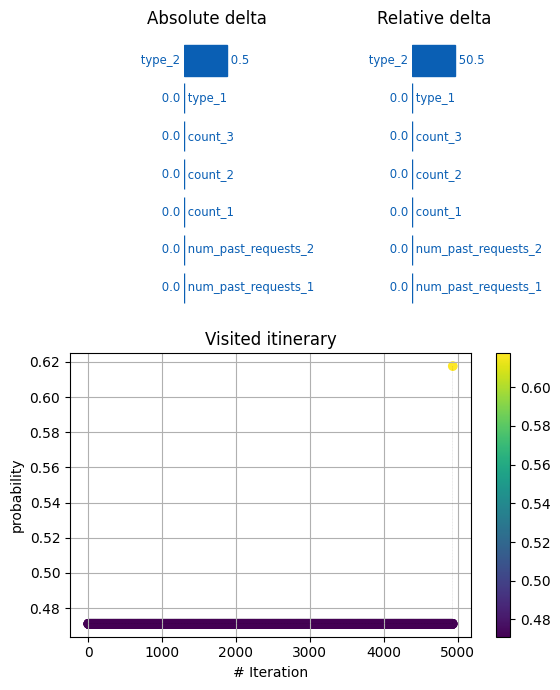

In [ ]:
explanation.show(figsize=(6, 7))

What we see is that we just need to change the type_2 feature to reach the specified prediction.

### ALE Plots

ALE plots show how model inputs affect the prediction on average. ALE Plots tend to be more reliable than Partial Dependence Plots in cases with correlations between different inputs.

We will use the `ALEExplainer`.

Here, we need to specify our prediction function.

In [ ]:
from mercury.explainability import ALEExplainer
from mercury.explainability.explainers.ale import plot_ale


model_4 = DecisionTreeClassifier(
    class_weight='balanced', max_depth=6
)


model_4 = model_4.fit(df_train[num_feats + cat_feats].to_numpy(), df_train[label_col])

ale = ALEExplainer(
    model_4.predict_proba,
    target_names=["neg", "pos"]
)

We select the features to explain and call `explain()`

In [ ]:
features_explain = [
    'num_past_requests_1', 'num_past_requests_2', 'num_1', 'num_4', 'rate_1', 'quantity_3'
]

exp = ale.explain(
    df_train[num_feats+cat_feats],
    ignore_features=[c for c in num_feats+cat_feats if c not in features_explain]
)

Now let's show the ALE plots. By selecting targets=[1] we indicate to show how changes the probability of default depending on the feature values

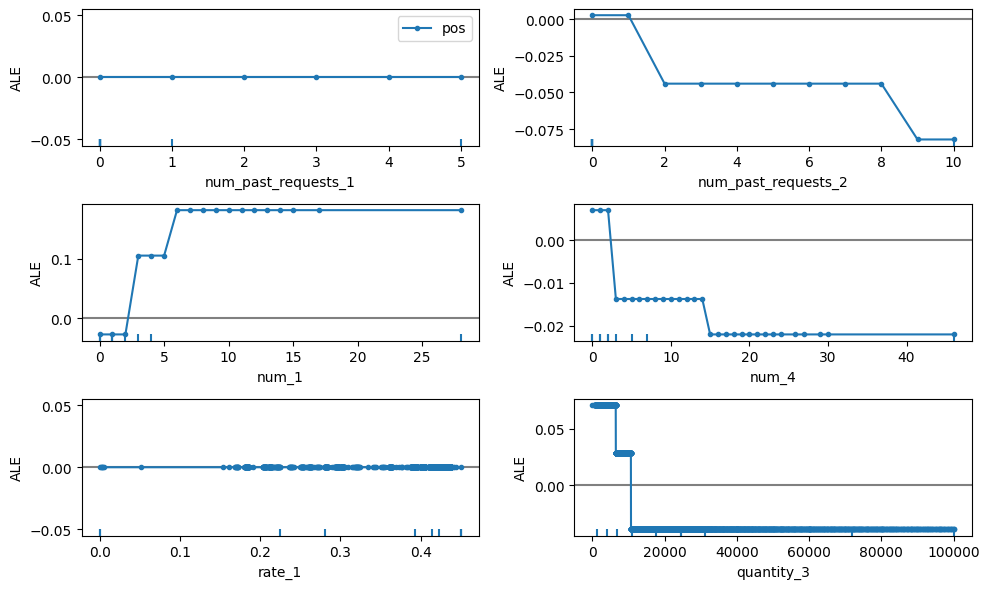

In [ ]:
plots = plot_ale(exp, n_cols=2, sharey=None, targets=[1], fig_kw={'figheight':6, 'figwidth':10})

We can see some insights about how the variables impact the model output, for example:
- `num_past_requests_1` doesn't seem to have an impact in the model output.
- When `num_past_requests_2` increases, the probability of our model predicting default decreases.
- When `num_1` increses, the probability of our model predicting default increases.


## Mercury-monitoring

[Mercury-monitoring](https://bbva.github.io/mercury-monitoring/site/) allows us to monitor data and model drift. In this case, we will use it to detect if there are changes in the input distribution.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/BBVA/mercury/refs/heads/master/src/data/finai_summit_2025/dataset.csv")
df = apply_preprocessing(df)

for f in schema.categorical_feats:
    df[f] = df[f].fillna(df[f].mode().values[0])

for f in schema.binary_feats:
    df[f] = df[f].fillna(df[f].mode().values[0])

for f in schema.discrete_feats:
    df[f] = df[f].fillna(df[f].median())

for f in schema.continuous_feats:
    df[f] = df[f].fillna(df[f].mean())


In [ ]:
df.head()

,id,payment_1,payment_2,num_past_requests_1,num_past_requests_2,count_1,count_2,count_3,count_4,count_5,quantity_1,type_1,pendent_quantity_1,pendent_quanitty_2,quantity_2,rate_1,rate_2,quantity_3,quantity_4,quantity_5,amount_1,type_2,num_1,num_2,num_3,num_4,time,target
0,4f03ec2f-4b6d-4155-8757-81199e8e13d8,5337.389698,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65016.928486,cat_1,31897.272162,61884.148318,10000.0,0.00,0.00,3087.638704,0.000000,0.0,74364.692653,cat_1,4.0,6.0,6.0,6.0,71,0
1,401773ca-2bdc-446c-a9c0-617dee9a576d,2201.926237,1999.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11685.636659,cat_1,44073.358198,9579.192701,0.0,0.45,0.45,10561.307148,13133.982905,0.0,11136.170566,cat_1,1.0,1.0,1.0,1.0,62,0
2,92c5e7fb-20df-406e-9692-4befb3b9e5e5,1744.594662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15461.902738,cat_1,0.000000,16275.765567,0.0,0.45,0.45,5278.532432,24187.065100,0.0,14816.045195,cat_1,1.0,2.0,2.0,1.0,54,0
3,0c2056b6-6e08-4439-bd1f-c15ae875e6b3,1513.461589,5098.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13735.191671,cat_1,200000.000000,15533.245177,0.0,0.45,0.45,100000.000000,153730.538199,0.0,12948.253204,cat_1,0.0,4.0,4.0,12.0,108,0
4,5f8f4609-ce85-4576-b142-e4a2b27bd7d4,5331.081746,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65077.193165,cat_1,0.000000,64284.183365,0.0,0.00,0.00,8829.275234,33239.583876,0.0,66405.616666,cat_1,0.0,3.0,3.0,1.0,109,0


Let's first check if we have drift between the time 21 and the time 90:

In [ ]:
df_time_21 = df[df["time"] == 21]
df_time_90 = df[df["time"] == 90]

### KS Drift

Let's check if we have data drift between time 21 and time 90. We will use the [`KSDrift`](https://bbva.github.io/mercury-monitoring/site/reference/drift/#mercury.monitoring.drift.ks_drift_detector.KSDrift), which allows to detect drift by calculating the Kolmogorov-Smirnov (KS) statistic. For each feature in the datasets, a KS test is performed. The method `calculate_drift()` returns a dictionary with different metrics. The key `drift_detected` is a boolean  indicating if drift was detected. The key `score` contains the average of all KS statistic computed for all features and it can be used as a measure to track drift. You can see more details in the documentation

In [ ]:
from mercury.monitoring.drift.ks_drift_detector import KSDrift

X_source = df_time_21[num_feats].to_numpy()
X_target = df_time_90[num_feats].to_numpy()

drift_detector = KSDrift(X_source, X_target, features=num_feats, p_val=0.05)
drift_metrics = drift_detector.calculate_drift()

print("Drift detected: ", drift_metrics["drift_detected"])
print("Drift score: ", drift_metrics["score"])

Drift detected:  True
Drift score:  0.1609709


We can see that drift was detected.

With the method `get_drifted_features()` we can see which features contain drift:

In [ ]:
drift_detector.get_drifted_features()

['payment_1', 'quantity_1', 'pendent_quanitty_2', 'quantity_4', 'quantity_5']

With the method `plot_feature_drift_scores` we can easily create a plot with the drift score for each feature.

<Axes: title={'center': 'feature drift scores'}>

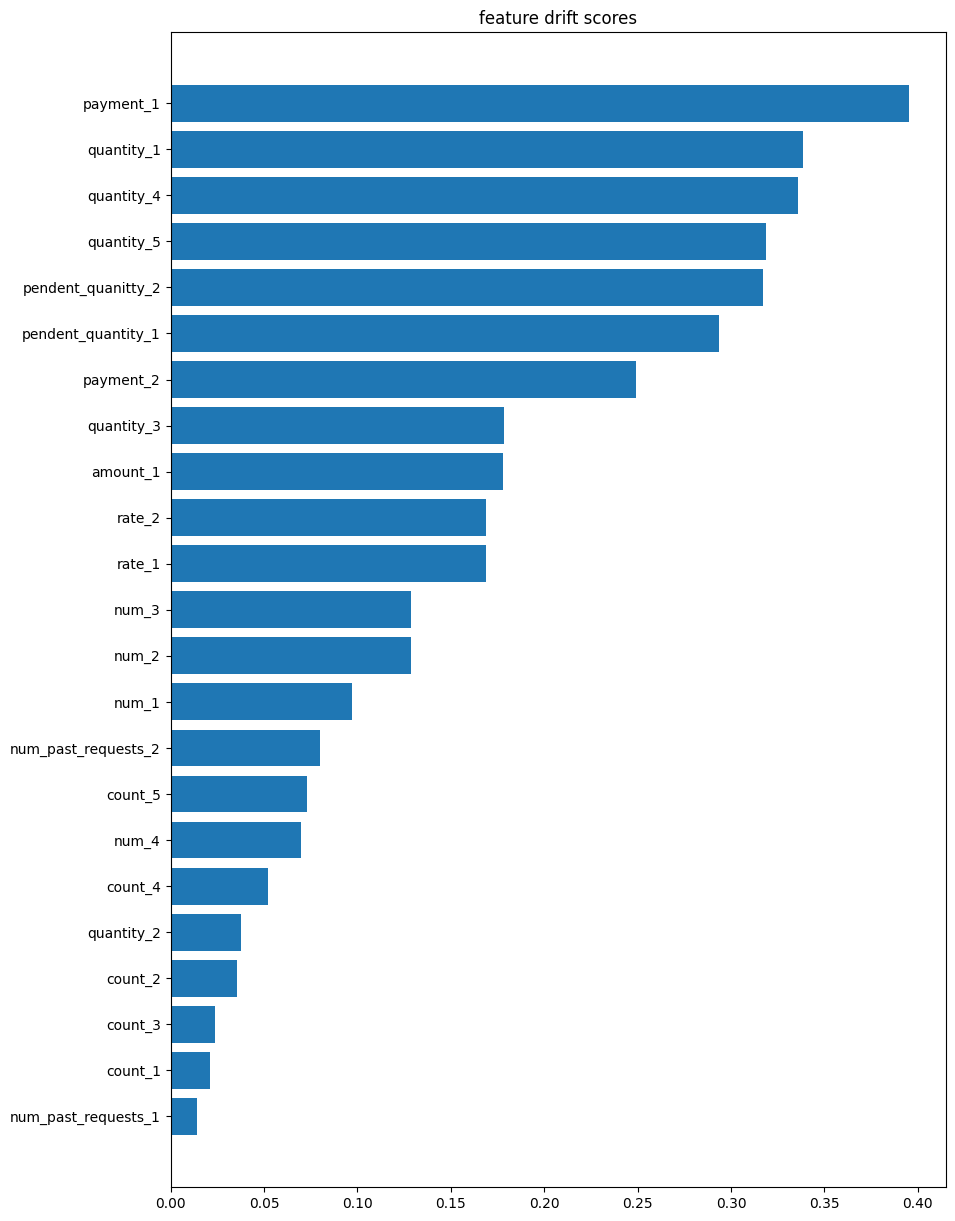

In [ ]:
drift_detector.plot_feature_drift_scores(figsize=(10,15))

In the previous plot, we can clearly see, in an ordered manner, the features that are most affected by the drift effect.

### DomainClassifier Drift

Now, we will use the [`DomainClassifierDrift`](https://bbva.github.io/mercury-monitoring/site/reference/drift/#mercury.monitoring.drift.domain_classifier_drift_detector.DomainClassifierDrift). It works similarly to the `KSDrift`, but in this case, it trains a classifier (Random Forest) to distinguish between a source dataset and a target dataset. If the better the classifier performance, the higher the data drift between both datasets.

In [ ]:
from mercury.monitoring.drift.domain_classifier_drift_detector import DomainClassifierDrift

X_source = df_time_21[num_feats].dropna().to_numpy()
X_target = df_time_90[num_feats].dropna().to_numpy()


drift_detector = DomainClassifierDrift(X_source, X_target, features=num_feats, p_val=0.05)
drift_metrics = drift_detector.calculate_drift()

print("Drift detected: ", drift_metrics["drift_detected"])
print("Drift score: ", drift_metrics["score"])

Drift detected:  True
Drift score:  0.7467548076923076


We can see that drift was detected

### Drift over time

Now, let's use the KSDrift to track drift overtime. We will consider our initial dataset the data previous to time 50, as calculate the drift for the following times

In [ ]:
df_train = df[df["time"] <= 70].copy()
df_inference = df[df["time"] > 70].copy()

print(len(df_train))
print(len(df_inference))

65145
34859


In [ ]:
drift_scores = []
drift_detections = []

for t in df_inference["time"].sort_values().unique():

    X_source = df_train[num_feats].to_numpy()
    X_target = df_inference[df_inference["time"] == t][num_feats].to_numpy()

    drift_detector = KSDrift(X_source, X_target, features=num_feats, p_val=0.05)
    drift_metrics = drift_detector.calculate_drift()

    drift_scores.append(drift_metrics["score"])
    drift_detections.append(drift_metrics["drift_detected"])


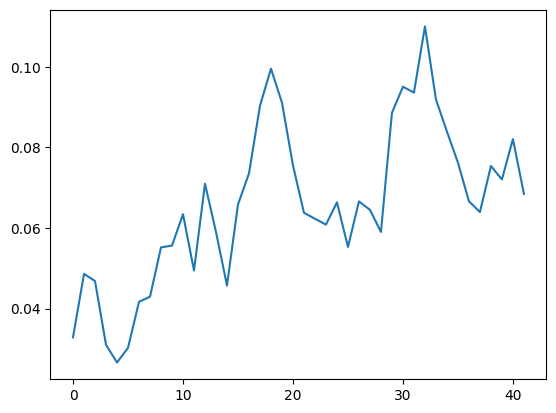

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

#x = np.linspace(0, 10, 1000)
ax.plot(np.arange(len(drift_scores)), drift_scores);

Overall, the data drift is increasing over time.